FineTuning TellMeWhy Dataset on T5 Base Model

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration,
    T5Tokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import warnings

warnings.filterwarnings('ignore')

def calculate_meteor(predictions, references, tokenizer):
    meteor_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = tokenizer.tokenize(pred)
        ref_tokens = tokenizer.tokenize(ref)
        
        meteor_scores.append(meteor_score([ref_tokens], pred_tokens))
    
    return sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

def calculate_bleu(predictions, references):
    smooth = SmoothingFunction().method4
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth))
    return sum(bleu_scores) / len(bleu_scores)

def calculate_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        rouge_scores['rouge1'].append(score['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(score['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(score['rougeL'].fmeasure)
    
    # Return average F1 scores for each ROUGE metric
    avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
    avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
    avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])
    
    return [avg_rouge1, avg_rouge2, avg_rougeL]

class TellMeWhyDataset(Dataset):
    def __init__(self, data_path: str, tokenizer, max_length: int = 384):  # Balanced sequence length
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = self.load_data(data_path)

    def load_data(self, data_path: str):
        processed_data = []
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                example = json.loads(line)
                # Only include answerable questions for better training
                if example['is_ques_answerable'] == 'Answerable':
                    processed_data.append({
                        'narrative': example['narrative'],
                        'question': example['question'],
                        'answer': example['answer']
                    })
        return processed_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        # Efficient but clear input format
        input_text = f"Question: {item['question']} Context: {item['narrative']}"
        target_text = item['answer']

        # Efficient tokenization
        inputs = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Shorter max length for answers
        targets = self.tokenizer(
            target_text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(),
            'attention_mask': inputs['attention_mask'].squeeze(),
            'labels': targets['input_ids'].squeeze()
        }


def train_t5(
    data_path: str,
    output_dir: str,
    num_epochs: int = 3,
    batch_size: int = 12,
    gradient_accumulation_steps: int = 16,
    learning_rate: float = 1e-4,
    max_length: int = 384,
    save_steps: int = 1000
):

    # Initialize model and tokenizer
    model_name = 't5-base'
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    model = T5ForConditionalGeneration.from_pretrained(model_name)

    # Enable gradient checkpointing for memory efficiency
    model.gradient_checkpointing_enable()

    # Prepare dataset and dataloader
    dataset = TellMeWhyDataset(data_path, tokenizer, max_length=max_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    # Setup training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    total_steps = (len(dataloader) // gradient_accumulation_steps) * num_epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    # Track losses and metrics
    record_losses, record_metrics, record_step_nos = [], [], []

    global_step = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()
        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

        all_preds, all_labels = [], []

        for step, batch in enumerate(progress_bar):
            # Move batch to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            # Calculate loss
            loss = outputs.loss / gradient_accumulation_steps
            loss.backward()

            # Update weights every gradient_accumulation_steps
            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                global_step += 1

                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.7f}'
                })

                total_loss += loss.item() * gradient_accumulation_steps

            if step+1 % 1000 == 0:
                # Decode predictions for metric calculation
                with torch.no_grad():
                    preds = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=128
                    )
                    decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
                    decoded_labels = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

                    all_preds.extend(decoded_preds)
                    all_labels.extend(decoded_labels)

        # Decode predictions for metric calculation
        with torch.no_grad():
            preds = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=128
            )
            decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            decoded_labels = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

            all_preds.extend(decoded_preds)
            all_labels.extend(decoded_labels)

        # Calculate and log metrics at the end of epoch
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        record_metrics.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        # Epoch-end statistics
        avg_loss = total_loss / len(dataloader)
        record_losses.append(avg_loss)
        record_step_nos.append(global_step)

        bleu_score = calculate_bleu(all_preds, all_labels)
        rouge_score = calculate_rouge(all_preds, all_labels)
        meteor_score_val = calculate_meteor(all_preds, all_labels, tokenizer)

        print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, BLEU: {bleu_score:.4f}, ROUGE Averages: {rouge_score}, Meteor: {meteor_score_val:.4f}')

        # Save epoch checkpoint
        model.save_pretrained(f'{output_dir}/epoch-{epoch+1}')
        tokenizer.save_pretrained(f'{output_dir}/epoch-{epoch+1}')

    # Save final model
    model.save_pretrained(f'{output_dir}/final_model')
    tokenizer.save_pretrained(f'{output_dir}/final_model')

    return list(zip(record_losses, record_step_nos, record_metrics))

FineTuning TellMeWhy Dataset on Base GPT2 Model

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import os
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import warnings

warnings.filterwarnings('ignore')

def calculate_meteor(predictions, references, tokenizer):
    meteor_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = tokenizer.tokenize(pred)
        ref_tokens = tokenizer.tokenize(ref)
        
        meteor_scores.append(meteor_score([ref_tokens], pred_tokens))
    
    return sum(meteor_scores) / len(meteor_scores) if meteor_scores else 0

def calculate_bleu(predictions, references):
    smooth = SmoothingFunction().method4
    bleu_scores = []
    for pred, ref in zip(predictions, references):
        pred_tokens = pred.split()
        ref_tokens = ref.split()
        bleu_scores.append(sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smooth))
    return sum(bleu_scores) / len(bleu_scores)

def calculate_rouge(predictions, references):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    for pred, ref in zip(predictions, references):
        score = scorer.score(ref, pred)
        rouge_scores['rouge1'].append(score['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(score['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(score['rougeL'].fmeasure)
    
    # Return average F1 scores for each ROUGE metric
    avg_rouge1 = sum(rouge_scores['rouge1']) / len(rouge_scores['rouge1'])
    avg_rouge2 = sum(rouge_scores['rouge2']) / len(rouge_scores['rouge2'])
    avg_rougeL = sum(rouge_scores['rougeL']) / len(rouge_scores['rougeL'])
    
    return [avg_rouge1, avg_rouge2, avg_rougeL]

class TellMeWhyDataset(Dataset):
    def __init__(self, data_path: str, tokenizer, max_length: int = 384):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = self.load_data(data_path)

    def load_data(self, data_path: str):
        processed_data = []
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                example = json.loads(line)
                if example['is_ques_answerable'] == 'Answerable':
                    processed_data.append({
                        'narrative': example['narrative'],
                        'question': example['question'],
                        'answer': example['answer']
                    })
        return processed_data

    def __getitem__(self, idx):
        item = self.data[idx]
        # Efficient prompt format
        input_text = f"Question: {item['question']}\nContext: {item['narrative']}\nAnswer: {item['answer']}"

        encodings = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': encodings['input_ids'].squeeze()
        }

    def __len__(self):
        return len(self.data)

def train_gpt2(
    data_path: str,
    output_dir: str,
    num_epochs: int = 5,
    batch_size: int = 12,
    gradient_accumulation_steps: int = 8,
    learning_rate: float = 1e-6,
    max_length: int = 384,
    save_steps: int = 1000
):
    os.makedirs(output_dir, exist_ok=True)

    # Initialize model and tokenizer
    model_name = 'gpt2'
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)

    # Add padding token
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = 'left'
    model.config.pad_token_id = model.config.eos_token_id

    # Enable gradient checkpointing
    model.gradient_checkpointing_enable()

    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    # Prepare dataset and dataloader
    dataset = TellMeWhyDataset(data_path, tokenizer, max_length=max_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Optimizer with weight decay
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01
    )

    # Track losses and metrics
    record_losses, record_metrics, record_step_nos = [], [], []

    total_steps = (len(dataloader) // gradient_accumulation_steps) * num_epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    global_step = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

        all_preds, all_labels = [], []

        for step, batch in enumerate(progress_bar):
            # Move batch to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss / gradient_accumulation_steps

            # Scale loss and backward pass
            scaler.scale(loss).backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                optimizer.zero_grad()

                global_step += 1

                progress_bar.set_postfix({
                    'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.7f}'
                })

                total_loss += loss.item() * gradient_accumulation_steps

            if step+1 % 1000 == 0:
                # Decode predictions for metric calculation
                with torch.no_grad():
                    preds = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=128
                    )
                    decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
                    decoded_labels = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

                    all_preds.extend(decoded_preds)
                    all_labels.extend(decoded_labels)

        # Decode predictions for metric calculation
        with torch.no_grad():
            preds = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=128
            )
            decoded_preds = [tokenizer.decode(p, skip_special_tokens=True) for p in preds]
            decoded_labels = [tokenizer.decode(l, skip_special_tokens=True) for l in labels]

            all_preds.extend(decoded_preds)
            all_labels.extend(decoded_labels)
            
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        record_metrics.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        # Epoch-end statistics
        avg_loss = total_loss / len(dataloader)
        record_losses.append(avg_loss)
        record_step_nos.append(global_step)

        bleu_score = calculate_bleu(all_preds, all_labels)
        rouge_score = calculate_rouge(all_preds, all_labels)
        meteor_score_val = calculate_meteor(all_preds, all_labels, tokenizer)

        print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, BLEU: {bleu_score:.4f}, ROUGE Averages: {rouge_score}, Meteor: {meteor_score_val:.4f}')

        # Save epoch checkpoint
        model.save_pretrained(f'{output_dir}/epoch-{epoch+1}')
        tokenizer.save_pretrained(f'{output_dir}/epoch-{epoch+1}')

    # Save final model
    model.save_pretrained(f'{output_dir}/final_model')
    tokenizer.save_pretrained(f'{output_dir}/final_model')

    # Return tracked losses and metrics for further analysis
    return list(zip(record_losses, record_step_nos, record_metrics))

DistilBert?

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DistilBertTokenizer,
    DistilBertForQuestionAnswering,
    AdamW,
    get_linear_schedule_with_warmup
)
from tqdm import tqdm
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class TellMeWhyDataset(Dataset):
    def __init__(self, data_path: str, tokenizer, max_length: int = 384):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = self.load_data(data_path)

    def load_data(self, data_path: str):
        processed_data = []
        with open(data_path, 'r', encoding='utf-8') as f:
            for line in f:
                example = json.loads(line)
                if example['is_ques_answerable'] == 'Answerable':
                    processed_data.append({
                        'narrative': example['narrative'],
                        'question': example['question'],
                        'answer': example['answer'],
                        'original_sentence_for_question' : example['original_sentence_for_question']
                    })
        return processed_data

    def __getitem__(self, idx):
        item = self.data[idx]

        # Treat "original_sentence_for_question" as the answer
        answer = item['original_sentence_for_question']
        context = item['narrative']

        # Generate the input text for tokenization
        input_text = f"<start_of_turn>user\nQuestion: {item['question']}\nContext: {context}<end_of_turn>\n<start_of_turn>assistant\nAnswer: {answer}<end_of_turn>"

        # Tokenize the input text
        encodings = self.tokenizer(
            input_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Find the start and end positions of the answer in the context (treat answer as a substring)
        start_pos = context.find(answer)
        end_pos = start_pos + len(answer) - 1

        # Convert to token indices
        start_token = len(self.tokenizer.encode(context[:start_pos]))
        end_token = len(self.tokenizer.encode(context[:end_pos+1]))

        # Adjust for padding (ensure indices are within max_length)
        start_token = min(start_token, self.max_length - 1)
        end_token = min(end_token, self.max_length - 1)

        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': encodings['input_ids'].squeeze(),
            'start_positions': torch.tensor(start_token),
            'end_positions': torch.tensor(end_token)
        }

    def __len__(self):
        return len(self.data)

# def train_distilbert(
#     data_path: str,
#     output_dir: str,
#     num_epochs: int = 3,
#     batch_size: int = 12,
#     gradient_accumulation_steps: int = 16,
#     learning_rate: float = 1e-4,
#     max_length: int = 384,
#     save_steps: int = 1000
# ):
#     os.makedirs(output_dir, exist_ok=True)

#     # Initialize model and tokenizer
#     model_name = "distilbert-base-uncased-distilled-squad"
#     tokenizer = DistilBertTokenizer.from_pretrained(model_name)
#     model = DistilBertForQuestionAnswering.from_pretrained(model_name)

#     # Enable gradient checkpointing
#     model.gradient_checkpointing_enable()

#     # Prepare dataset and dataloader
#     dataset = TellMeWhyDataset(data_path, tokenizer, max_length=max_length)
#     dataloader = DataLoader(
#         dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=0,
#         pin_memory=True
#     )

#     # Optimizer with weight decay
#     optimizer = AdamW(
#         model.parameters(),
#         lr=learning_rate,
#         weight_decay=0.01
#     )

#     total_steps = (len(dataloader) // gradient_accumulation_steps) * num_epochs

#     scheduler = get_linear_schedule_with_warmup(
#         optimizer,
#         num_warmup_steps=total_steps // 10,
#         num_training_steps=total_steps
#     )

#     # Setup training
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#     model.to(device)

#     # Track losses for checkpoints and printing
#     record_losses, record_step_nos = [], []

#     global_step = 0
#     best_loss = float('inf')

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss = 0
#         optimizer.zero_grad()

#         progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

#         for step, batch in enumerate(progress_bar):
#             # Move batch to GPU and ensure proper gradient accumulation
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['labels'].to(device)
#             start_positions = batch['start_positions'].to(device)
#             end_positions = batch['end_positions'].to(device)

#             # Forward pass through the model
#             outputs = model(
#                 input_ids=input_ids,
#                 attention_mask=attention_mask,
#                 start_positions=start_positions,
#                 end_positions=end_positions
#             )

#             # Check if loss is calculated
#             if outputs.loss is None:
#                 print("Error: Loss is None")
#                 continue  # Skip this batch if the loss is None

#             loss = outputs.loss / gradient_accumulation_steps
#             loss.backward()

#             global_step += 1

#             if (step + 1) % gradient_accumulation_steps == 0:
#                 torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
#                 optimizer.step()
#                 scheduler.step()
#                 optimizer.zero_grad()  # Zero gradients after updating the optimizer

#                 progress_bar.set_postfix({
#                     'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
#                     'lr': f'{scheduler.get_last_lr()[0]:.7f}'
#                 })

#                 # Save best model
#                 current_loss = loss.item() * gradient_accumulation_steps
#                 if current_loss < best_loss:
#                     best_loss = current_loss
#                     model.save_pretrained(f'{output_dir}/best_model')
#                     tokenizer.save_pretrained(f'{output_dir}/best_model')

#                 # Regular checkpoints
#                 if global_step % save_steps == 0:
#                     checkpoint_dir = f'{output_dir}/checkpoint-{global_step}'
#                     model.save_pretrained(checkpoint_dir)
#                     tokenizer.save_pretrained(checkpoint_dir)

#                 total_loss += loss.item() * gradient_accumulation_steps

#         avg_loss = total_loss / len(dataloader)
#         print(f'Epoch {epoch+1} average loss: {avg_loss:.4f}')

#         # Save losses for plotting
#         record_losses.append(avg_loss)
#         record_step_nos.append(global_step)

#         # Save epoch checkpoint
#         model.save_pretrained(f'{output_dir}/epoch-{epoch+1}')
#         tokenizer.save_pretrained(f'{output_dir}/epoch-{epoch+1}')

#     # Save final model
#     model.save_pretrained(f'{output_dir}/final_model')
#     tokenizer.save_pretrained(f'{output_dir}/final_model')

#     # Return tracked losses and steps for further analysis
#     return list(zip(record_losses, record_step_nos))
def train_distilbert(
    data_path: str,
    output_dir: str,
    num_epochs: int = 5,
    batch_size: int = 12,
    gradient_accumulation_steps: int = 16,
    learning_rate: float = 1e-4,
    max_length: int = 384,
    save_steps: int = 1000
):
    os.makedirs(output_dir, exist_ok=True)

    # Initialize model and tokenizer
    model_name = "distilbert-base-uncased-distilled-squad"
    tokenizer = DistilBertTokenizer.from_pretrained(model_name)
    model = DistilBertForQuestionAnswering.from_pretrained(model_name)

    # Enable gradient checkpointing
    model.gradient_checkpointing_enable()

    # Prepare dataset and dataloader
    dataset = TellMeWhyDataset(data_path, tokenizer, max_length=max_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True
    )

    # Optimizer with weight decay
    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=0.01
    )

    total_steps = (len(dataloader) // gradient_accumulation_steps) * num_epochs

    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=total_steps // 10,
        num_training_steps=total_steps
    )

    # Setup training
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Track losses and metrics
    record_losses, record_metrics, record_step_nos = [], [], []

    global_step = 0
    best_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        optimizer.zero_grad()

        progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

        all_preds, all_labels = [], []

        for step, batch in enumerate(progress_bar):
            # Move batch to GPU
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                start_positions=start_positions,
                end_positions=end_positions
            )

            loss = outputs.loss / gradient_accumulation_steps
            loss.backward()

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

                global_step += 1

                progress_bar.set_postfix({
                    'loss': f'{loss.item() * gradient_accumulation_steps:.4f}',
                    'lr': f'{scheduler.get_last_lr()[0]:.7f}'
                })

                # Save best model
                current_loss = loss.item() * gradient_accumulation_steps
                if current_loss < best_loss:
                    best_loss = current_loss
                    model.save_pretrained(f'{output_dir}/best_model')
                    tokenizer.save_pretrained(f'{output_dir}/best_model')

                # Regular checkpoints
                if global_step % save_steps == 0:
                    checkpoint_dir = f'{output_dir}/checkpoint-{global_step}'
                    model.save_pretrained(checkpoint_dir)
                    tokenizer.save_pretrained(checkpoint_dir)

            total_loss += loss.item() * gradient_accumulation_steps

            # Decode predictions for metric calculation
            with torch.no_grad():
                start_logits = outputs.start_logits.argmax(dim=1)
                end_logits = outputs.end_logits.argmax(dim=1)

                for i in range(len(start_logits)):
                    pred_answer = tokenizer.decode(
                        input_ids[i][start_logits[i]:end_logits[i] + 1]
                    )
                    true_answer = tokenizer.decode(
                        input_ids[i][start_positions[i]:end_positions[i] + 1]
                    )

                    all_preds.append(pred_answer)
                    all_labels.append(true_answer)

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        record_metrics.append({
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

        avg_loss = total_loss / len(dataloader)
        record_losses.append(avg_loss)
        record_step_nos.append(global_step)

        print(f'Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')

        # Save epoch checkpoint
        model.save_pretrained(f'{output_dir}/epoch-{epoch+1}')
        tokenizer.save_pretrained(f'{output_dir}/epoch-{epoch+1}')

    # Save final model
    model.save_pretrained(f'{output_dir}/final_model')
    tokenizer.save_pretrained(f'{output_dir}/final_model')

    # Return tracked losses and metrics for further analysis
    return list(zip(record_losses, record_step_nos, record_metrics))

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\antee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\antee\AppData\Roaming\nltk_data...


True

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Epoch 1/3: 100%|██████████| 4501/4501 [1:19:50<00:00,  1.06s/it, loss=0.1339, lr=0.0000740]


Epoch 1 - Loss: 0.1176, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.0198, ROUGE Averages: [0.15132275132275133, 0.025641025641025637, 0.15132275132275133], Meteor: 0.1293


Epoch 2/3: 100%|██████████| 4501/4501 [1:22:55<00:00,  1.11s/it, loss=0.0998, lr=0.0000370]


Epoch 2 - Loss: 0.0077, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.0327, ROUGE Averages: [0.19675925925925927, 0.08333333333333333, 0.17592592592592593], Meteor: 0.1827


Epoch 3/3: 100%|██████████| 4501/4501 [1:20:53<00:00,  1.08s/it, loss=0.1366, lr=0.0000000]


Epoch 3 - Loss: 0.0073, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.0703, ROUGE Averages: [0.28961988304093567, 0.11613876319758672, 0.28961988304093567], Meteor: 0.2429


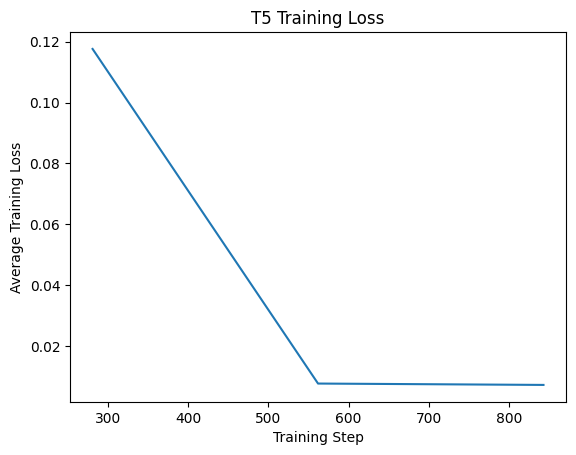

In [2]:
if __name__ == '__main__':
    # Set paths
    data_path = './Dataset/train.json'
    output_dir = './T5Output/'

plot_losses = train_t5(
    data_path=data_path,
    output_dir=output_dir,
)

# Plot the loss over time
record_losses, record_step_nos, record_metrics = zip(*plot_losses)
plt.plot(record_step_nos, record_losses)
plt.xlabel("Training Step")
plt.ylabel("Average Training Loss")
plt.title("T5 Training Loss")
plt.show()

Epoch 1/5: 100%|██████████| 4501/4501 [29:17<00:00,  2.56it/s, loss=0.9878, lr=0.0000009]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Epoch 1 - Loss: 0.3649, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.3787, ROUGE Averages: [0.5559559049272461, 0.5515263745053649, 0.5559559049272461], Meteor: 0.7614


Epoch 2/5: 100%|██████████| 4501/4501 [31:11<00:00,  2.41it/s, loss=0.7396, lr=0.0000007]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Epoch 2 - Loss: 0.1008, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.4096, ROUGE Averages: [0.5886468273084915, 0.5850034509102046, 0.5886468273084915], Meteor: 0.8070


Epoch 3/5: 100%|██████████| 4501/4501 [28:54<00:00,  2.60it/s, loss=0.6383, lr=0.0000004]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Epoch 3 - Loss: 0.0862, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.3882, ROUGE Averages: [0.5656959320875496, 0.5616408901389472, 0.5656959320875496], Meteor: 0.7808


Epoch 4/5: 100%|██████████| 4501/4501 [28:26<00:00,  2.64it/s, loss=0.6735, lr=0.0000002]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Epoch 4 - Loss: 0.0802, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.3880, ROUGE Averages: [0.5632724093828508, 0.559063391956793, 0.5632724093828508], Meteor: 0.7670


Epoch 5/5: 100%|██████████| 4501/4501 [29:48<00:00,  2.52it/s, loss=0.5983, lr=0.0000000]
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Epoch 5 - Loss: 0.0771, Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1: 0.0000, BLEU: 0.3962, ROUGE Averages: [0.5782298087269214, 0.5743196524428887, 0.5782298087269214], Meteor: 0.7617


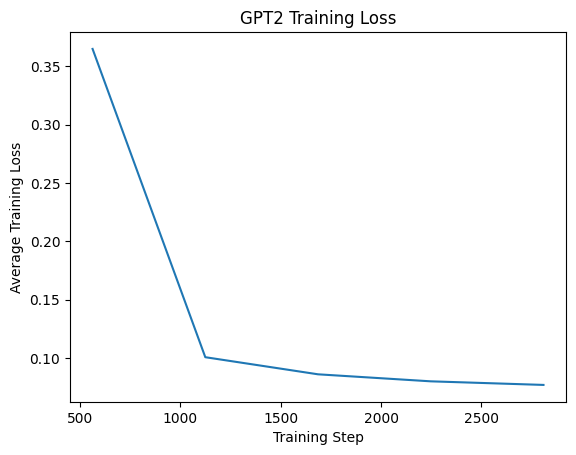

In [2]:
if __name__ == '__main__':
    # Set paths
    data_path = './Dataset/train.json'
    output_dir = './GPT2OutputNew/'

plot_losses = train_gpt2(
    data_path=data_path,
    output_dir=output_dir,
)

# Plot the loss over time
record_losses, record_step_nos, record_metrics = zip(*plot_losses)
plt.plot(record_step_nos, record_losses)
plt.xlabel("Training Step")
plt.ylabel("Average Training Loss")
plt.title("GPT2 Training Loss")
plt.show()

In [2]:
if __name__ == '__main__':
    # Set paths
    data_path = './Dataset/train.json'
    output_dir = './Output/DistilBertOutputFinal/'

    plot_losses = train_distilbert(
        data_path=data_path,
        output_dir=output_dir,
    )

    # Plot the loss over time
    record_losses, record_step_nos, record_metrics = zip(*plot_losses)
    plt.plot(record_step_nos, record_losses)
    plt.xlabel("Training Step")
    plt.ylabel("Average Training Loss")
    plt.title("DistilBert Training Loss")
    plt.show()

C:\Users\antee\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5: 100%|██████████| 4501/4501 [24:46<00:00,  3.03it/s, loss=1.2505, lr=0.0000889]


Epoch 1 - Loss: 2.2584, Accuracy: 0.1193, Precision: 0.2628, Recall: 0.1193, F1: 0.1571


Epoch 2/5: 100%|██████████| 4501/4501 [23:42<00:00,  3.16it/s, loss=0.7021, lr=0.0000666]


Epoch 2 - Loss: 0.8145, Accuracy: 0.4593, Precision: 0.7738, Recall: 0.4593, F1: 0.5510


Epoch 3/5: 100%|██████████| 4501/4501 [24:49<00:00,  3.02it/s, loss=0.3596, lr=0.0000444]


Epoch 3 - Loss: 0.4490, Accuracy: 0.6848, Precision: 0.9286, Recall: 0.6848, F1: 0.7633


Epoch 4/5: 100%|██████████| 4501/4501 [25:09<00:00,  2.98it/s, loss=0.0498, lr=0.0000222]


Epoch 4 - Loss: 0.2429, Accuracy: 0.8262, Precision: 0.9772, Recall: 0.8262, F1: 0.8779


Epoch 5/5: 100%|██████████| 4501/4501 [24:44<00:00,  3.03it/s, loss=0.0488, lr=0.0000000]


Epoch 5 - Loss: 0.1402, Accuracy: 0.9030, Precision: 0.9891, Recall: 0.9030, F1: 0.9337


NameError: name 'plt' is not defined

In [20]:
if __name__ == '__main__':
    # Set paths
    data_path = './Dataset/train.json'
    output_dir = './DistilbertOutputFinal/'

    plot_losses = train_distilbert(
        data_path=data_path,
        output_dir=output_dir,
    )

    # Plot the loss over time
    record_losses, record_step_loss, record_recall_start, record_recall_end, record_precision_start, record_precision_end, record_f1_start, record_f1_end, record_metrics_epoch = zip(*plot_losses)

    plt.plot(record_step_loss, record_losses)
    plt.xlabel("Training Step")
    plt.ylabel("Average Training Loss")
    plt.title("DistilBert Training Loss")
    plt.show()

    plt.plot(record_metrics_epoch, record_recall_start)
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("DistilBert Starting Recall")
    plt.show()

    plt.plot(record_metrics_epoch, record_recall_end)
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("DistilBert Ending Recall")
    plt.show()

    plt.plot(record_metrics_epoch, record_precision_start)
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("DistilBert Starting Precision")
    plt.show()

    plt.plot(record_metrics_epoch, record_precision_end)
    plt.xlabel("Epoch")
    plt.ylabel("Precision")
    plt.title("DistilBert Ending Precision")
    plt.show()

    plt.plot(record_metrics_epoch, record_f1_start)
    plt.xlabel("Epoch")
    plt.ylabel("F1")
    plt.title("DistilBert Starting F1")
    plt.show()

    plt.plot(record_metrics_epoch, record_f1_end)
    plt.xlabel("Epoch")
    plt.ylabel("Recall")
    plt.title("DistilBert Ending F1")
    plt.show()

C:\Users\antee\AppData\Roaming\Python\Python312\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/5:   2%|▏         | 94/4501 [00:36<28:53,  2.54it/s, loss=8.1334, lr=0.0000036]


KeyboardInterrupt: 